# Introduction to Adversarial Robustness

*SE2 Current Topics in Data Science, Universitätslehrgang Data Science*

**Date: November 20, 2021**


## Preliminaries

For the practice session, we are going to use the `adversarial-robustness-toolbox` (ART) package, which can be installed via `pip install adversarial-robustness-toolbox[pytorch]`.

ART is a Python library for machine learning security. It provides a broad set of tools to defend and evaluate machine learning models. It covers adversarial threats like evasion, poisoning, extraction and inference attacks as well as suitable defenses. It supports all popular machine learning frameworks.

Today we will use ART in combination with **PyTorch**. We will explore some common evasion attacks and demonstrate how ART's defense tools can be used.

**Notes:**

The notebook requires some dependencies, which are found in `requirements.txt`. We recommend that you run the notebook in an virtual environment.

In [1]:
# # Uncomment this cell, if you want to run it
# %pip install -r requirements.txt

**Agenda:**

1. Initialize Perfect-Knowledge Setting
1. PGD evasion attacks
1. Breaking a ad-hoc defense: Spatial Smoothing Defense
1. Certified Robustness

## Initialize Perfect-Knowledge Setting

In [2]:
import json
import warnings
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms


from art.config import ART_DATA_PATH
from art.utils import get_file
from art.estimators.classification import PyTorchClassifier

# disable an annoying depcreation warning that is due to latest ipython
warnings.filterwarnings("ignore", category=DeprecationWarning)

# download imagenet class index
imagenet_labels_uri = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
imagenet_labels_path = get_file("imagenet_class_index.json", imagenet_labels_uri)

with open(imagenet_labels_path, "r") as f:
    IMAGENET_CLASS_INDEX = json.load(f)
    
# return label name for label index
def label_name(label_id: int) -> str:
    return IMAGENET_CLASS_INDEX[str(label_id)][-1]

We are mounting our attacks on a ResNet-50 model that is trained on the ImageNet dataset. 

In [3]:
# load a pretrained ResNet-50 model
resnet = models.resnet50(pretrained=True, progress=True)

# set model evaluation mode
resnet.eval()

# define appropriate model loss
loss = torch.nn.CrossEntropyLoss()

The GitHub repositoy [imagenet-stubs](https://github.com/nottombrown/imagenet-stubs/raw/master/imagenet_stubs/images/) hosts a selection of ImageNet samples. We choose the Koala sample and download it. 

PyTorch's model zoo (`torchvision.models`) offers some guidance how the ImageNet samples are to be preprocessed. The following steps are required:

* Load image in to a range of `[0,1]`.
* Standardize the sample with a mean of `(0.485, 0.456, 0.406)` and standard deviation of `(0.229, 0.224, 0.225)`.
* Resize image to `256x256` and center crop to `224x224`.
* Transform image shape to `(batch_size, channels, height, width)`


In [4]:
# download test image
test_image_path = get_file("koala.jpg", 
                           "https://github.com/nottombrown/imagenet-stubs/raw/master/imagenet_stubs/images/koala.jpg")
# test_image_path = get_file("gazelle.jpg", 
#                            "https://github.com/nottombrown/imagenet-stubs/raw/master/imagenet_stubs/images/gazelle.jpg")
# test_image_path = get_file("tractor.jpg", 
#                            "https://github.com/nottombrown/imagenet-stubs/raw/master/imagenet_stubs/images/tractor.jpg")

# define imagenet mean and standard deviation
imagenet_mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
imagenet_std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# resisze to 256x256
img = Image.open(test_image_path)
img_resized = img.resize((256, 256), Image.ANTIALIAS)

# center crop to 224x224
def crop_img(img, height, width):
    "Resize image to (256, 256) and center crop to (height, width)."
    img_resized = img.resize((256, 256), Image.ANTIALIAS)

    orig_w, orig_h = img_resized.size
    left = (orig_w - width) // 2
    top = (orig_h - height) // 2
    right = (orig_w + width) // 2
    bottom = (orig_h + height) // 2
    return img.crop((left, top, right, bottom))
img_cropped = crop_img(img_resized, 224, 224)

# convert image to normalized np.ndarray 
x = np.array(img_cropped, dtype=np.float32) / 255

# standardize image
x_preprocessed = (x - imagenet_mean) / imagenet_std

# batchify image and 
x_batch = np.expand_dims(np.transpose(x_preprocessed, (2, 0, 1)), axis=0)

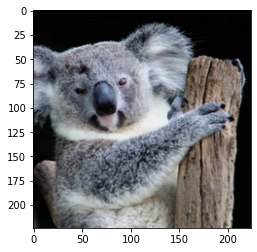

In [5]:
plt.imshow(x)

We have now all our compoments at hands that are required for a perfect-knowledge attack. Remember, that we require

* knowledge over the model $f$ and weights $\mathbf{w}$
* knowledge of the feature space and training data

Now, we can set up a ART classification estimator, which serves as the main interface for the evasion attacks.

In [6]:
?PyTorchClassifier

In [7]:
# define ART classification estimator
model = PyTorchClassifier(
    resnet,
    loss,
    (1, 3, 224, 224),
    nb_classes=1000,
    channels_first=True
)

# test estimator
print(f"Prediction original: {label_name(np.argmax(model.predict(x_batch)))} ({1 / (1 + np.exp(-np.max(model.predict(x_batch))))})")

Prediction original: koala (0.9999999981472911)


## Evasion attacks

In [8]:
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import to_categorical

### Projected Gradient Descent

Let's apply an targeted Projected Gradient Descent attack now.

In [9]:
?ProjectedGradientDescent

In [10]:
print("Imagenet class index:")
[print(f"\t{idx} -> {label_lst[-1]}") for idx, label_lst in IMAGENET_CLASS_INDEX.items()]

Imagenet class index:
	0 -> tench
	1 -> goldfish
	2 -> great_white_shark
	3 -> tiger_shark
	4 -> hammerhead
	5 -> electric_ray
	6 -> stingray
	7 -> cock
	8 -> hen
	9 -> ostrich
	10 -> brambling
	11 -> goldfinch
	12 -> house_finch
	13 -> junco
	14 -> indigo_bunting
	15 -> robin
	16 -> bulbul
	17 -> jay
	18 -> magpie
	19 -> chickadee
	20 -> water_ouzel
	21 -> kite
	22 -> bald_eagle
	23 -> vulture
	24 -> great_grey_owl
	25 -> European_fire_salamander
	26 -> common_newt
	27 -> eft
	28 -> spotted_salamander
	29 -> axolotl
	30 -> bullfrog
	31 -> tree_frog
	32 -> tailed_frog
	33 -> loggerhead
	34 -> leatherback_turtle
	35 -> mud_turtle
	36 -> terrapin
	37 -> box_turtle
	38 -> banded_gecko
	39 -> common_iguana
	40 -> American_chameleon
	41 -> whiptail
	42 -> agama
	43 -> frilled_lizard
	44 -> alligator_lizard
	45 -> Gila_monster
	46 -> green_lizard
	47 -> African_chameleon
	48 -> Komodo_dragon
	49 -> African_crocodile
	50 -> American_alligator
	51 -> triceratops
	52 -> thunder_snake
	53 -> rin

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [11]:
pgd = ProjectedGradientDescent(
    estimator=model,
    norm=np.inf,
    targeted=True,
    eps=5/255,
    eps_step=1/255,
    max_iter=10,
    batch_size=1,
)

y_target = to_categorical([21], nb_classes=1000) 
x_adv = pgd.generate(x_batch, y=y_target)

print(f"Target label: {label_name(21)}")
print(f"Prediction adversarial: {label_name(np.argmax(model.predict(x_adv)))} ({1 / (1 + np.exp(-np.max(model.predict(x_adv))))})")

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Target label: kite
Prediction adversarial: kite (0.999802451221959)


Min pixel: 0.0
Max pixel: 0.9769607782363892


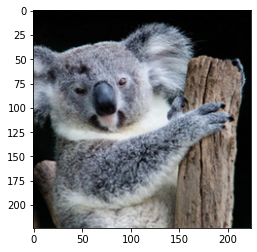

In [12]:
x_adv_unnormalized = np.clip(np.transpose(np.squeeze(x_adv) , (1, 2, 0)) * imagenet_std + imagenet_mean, 0, 1)

print(f"Min pixel: {x_adv_unnormalized.min()}")
print(f"Max pixel: {x_adv_unnormalized.max()}")

plt.imshow(x_adv_unnormalized)

Next, let's try to make our previous FGSM iterative and project the perturbation $\delta$ on the $l_\infty$-ball.

In [13]:
##################
# Try-yourself 1 #
##################

# define
x_torch_orig = torch.from_numpy(x_batch)
x_torch_adv = torch.from_numpy(x_batch)

# try to run multiple iterations. What's the smallest number of iterations you need?
for i in range(10):
    # we require gradients for the attack
    x_torch_adv.requires_grad = True

    # To-Do: calculate loss for (x, y_true) pair (tip: check some of the previous cells)
    loss_tensor = loss(resnet(x_torch_adv), torch.LongTensor([21]))

    # backward pass on loss
    loss_tensor.backward()
    
    # get gradients
    grad = x_torch_adv.grad.data
    
    with torch.no_grad():
        # To-Do: peform a gradient descent step with step size of 1/255
        x_torch_adv = x_torch_adv - 1/255 * grad.sign()
        
        # To-Do: clip perturbation delta at 5/255
        delta = torch.clip(x_torch_adv - x_torch_orig, min=-5/255, max=5/255)
        
        # re-apply delta to original example
        x_torch_adv = x_torch_orig + delta

# save adversarial as numpy array        
x_adv = x_torch_adv.detach().numpy()

In [14]:
print(f"Target label: {label_name(21)}")
print(f"Prediction adversarial: {label_name(np.argmax(model.predict(x_adv)))} ({1 / (1 + np.exp(-np.max(model.predict(x_adv))))})")    

Target label: kite
Prediction adversarial: kite (0.999802451221959)


## Spatial Smoothing Defense

ART also provides a set of defenses. Namely, pre- and postprocessing defenses as well as adversarial training. We will use the spatial smoothing defense and try to circumvent it afterwards.

In [15]:
from art.defences.preprocessor import SpatialSmoothing

In [16]:
# define spatial smoothing defense
defense = SpatialSmoothing(window_size=3)

# re-generate adversarial example with PGD
pgd = ProjectedGradientDescent(
    estimator=model,
    norm=np.inf,
    targeted=True,
    eps=5/255,
    eps_step=1/255,
    max_iter=20,
    batch_size=1,
)

y_target = to_categorical([21], nb_classes=1000) 
x_adv = pgd.generate(x_batch, y=y_target)

# apply defense to original and adversarial example
x_batch_defense, _ = defense(x_batch)
x_adv_defense, _ = defense(x_adv)

print(f"Target label: {label_name(21)}")
print(f"Prediction adversarial: {label_name(np.argmax(model.predict(x_adv)))} ({1 / (1 + np.exp(-np.max(model.predict(x_adv))))})")
print(f"Prediction original after defense: {label_name(np.argmax(model.predict(x_batch_defense)))} ({1 / (1 + np.exp(-np.max(model.predict(x_batch_defense))))})")
print(f"Prediction adversarial after defense: {label_name(np.argmax(model.predict(x_adv_defense)))} ({1 / (1 + np.exp(-np.max(model.predict(x_adv_defense))))})")

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Target label: kite
Prediction adversarial: kite (0.999998365186742)
Prediction original after defense: koala (0.9999999790341794)
Prediction adversarial after defense: koala (0.9999997387506142)


Min pixel: 0.0
Max pixel: 0.957352876663208


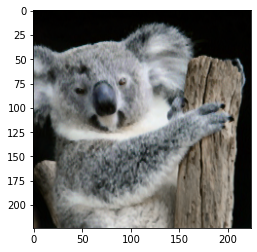

In [17]:
x_adv_defense_unnormalized = np.clip(np.transpose(np.squeeze(x_adv_defense) , (1, 2, 0)) * imagenet_std + imagenet_mean, 0, 1)

print(f"Min pixel: {x_adv_defense_unnormalized.min()}")
print(f"Max pixel: {x_adv_defense_unnormalized.max()}")

plt.imshow(x_adv_defense_unnormalized)

Now let's try to employ an adaptive whitebox attack to defeat the spatial smoothing defense.

In [18]:
##################
# Try-yourself 2 #
##################

# define spatial smoothing defense
defense = SpatialSmoothing(window_size=3)

# define adaptive classifier
model_adaptive = PyTorchClassifier(
    resnet,
    loss,
    (1, 3, 224, 224),
    nb_classes=1000,
    channels_first=True,
    # To-Do: Have a look a the documentation. What possible argument could be useful?
    preprocessing_defences=[defense],
)


# re-generate adversarial example with PGD
pgd_adaptive = ProjectedGradientDescent(
    estimator=model_adaptive,
    norm=np.inf,
    targeted=True,
    eps=5/255,
    eps_step=1/255,
    batch_size=1,
    # To-Do: Play around with max_iter. How many iterations are required?
    max_iter=60,
)

y_target = to_categorical([21], nb_classes=1000) 
x_adv_adaptive = pgd_adaptive.generate(x_batch, y=y_target)

print(f"Target label: {label_name(21)}")
print(f"Prediction adversarial adaptive: {label_name(np.argmax(model_adaptive.predict(x_adv_adaptive)))} ({1 / (1 + np.exp(-np.max(model_adaptive.predict(x_adv_adaptive))))})")

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/60 [00:00<?, ?it/s]

Target label: kite
Prediction adversarial adaptive: kite (0.9992320602349992)


Min pixel: 0.0
Max pixel: 0.9769607782363892


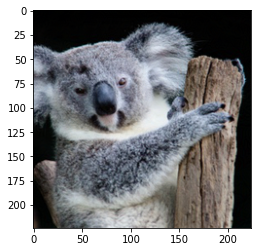

In [19]:
x_adv_adaptive_unnormalized = np.clip(np.transpose(np.squeeze(x_adv_adaptive) , (1, 2, 0)) * imagenet_std + imagenet_mean, 0, 1)

print(f"Min pixel: {x_adv_adaptive_unnormalized.min()}")
print(f"Max pixel: {x_adv_adaptive_unnormalized.max()}")

plt.imshow(x_adv_adaptive_unnormalized)

## Certified Robustness

With ART we can easily obtain certified robustness guarantees via randomized smoothing.

In [20]:
from art.estimators.certification.randomized_smoothing import PyTorchRandomizedSmoothing
from art.utils import load_mnist, compute_accuracy

Before we continue, let's load the MNIST dataset and define a small neural network to train our randomized smoother with.

In [21]:
?PyTorchRandomizedSmoothing

In [22]:
# parameters
nb_epochs = 40
batch_size = 128
sample_size = 100
sigma = 0.25
alpha = 0.001
num_samples_test = 250

# Step 0: Define the neural network model, return logits instead of activation in forward method
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = torch.nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = torch.nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

x_test = x_test[0:num_samples_test]
y_test = y_test[0:num_samples_test]

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

# Step 2: Create the model

model = Net()

# Step 2a: Define the loss function and the optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create randomized smoothing classifier

classifier = PyTorchRandomizedSmoothing(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    channels_first=True,
    input_shape=(1, 28, 28),
    sample_size=sample_size,
    nb_classes=10,
    scale=sigma,
    alpha=alpha,
)

# Step 4: Train the randomized smoothing classifier
classifier.fit(x_train, y_train, nb_epochs=nb_epochs, batch_size=batch_size)

# To-Do: While the classifier is training, have a look at adversarial training:
# https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_training_mnist.ipynb

In [23]:
# Step 5: Verify accuracy of randomized classifier
x_preds = classifier.predict(x_test)
acc, cov = compute_accuracy(x_preds, y_test)

print("\nSmoothed Classifier, sigma=" + str(sigma))
print("Accuracy: {}".format(acc))
print("Coverage: {}".format(cov))

Randomized smoothing:   0%|          | 0/250 [00:00<?, ?it/s]


Smoothed Classifier, sigma=0.25
Accuracy: 0.9959677419354839
Coverage: 0.992


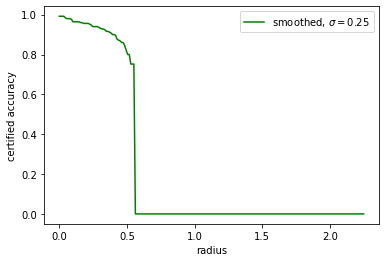

In [24]:
# Step 6: Calculate certification accuracy for a given radius
def getCertAcc(radius, pred, y_test):

    rad_list = np.linspace(0, 2.25, 201)
    cert_acc = []
    num_cert = len(radius)
    
    for r in rad_list:
        rad_idx = np.where(radius >= r)[0]
        y_test_subset = y_test[rad_idx]
        cert_acc.append(np.sum(pred[rad_idx] == np.argmax(y_test_subset, axis=1)) / num_cert)
        
    return cert_acc

# Compute certification
prediction, radius = classifier.certify(x_test, n=500)

# Plot certification accuracy w.r.t. to radius
rad_list = np.linspace(0, 2.25, 201)
plt.plot(rad_list, getCertAcc(radius, prediction, y_test), '-', color='green',
         label='smoothed, $\sigma=$' + str(0.25))

plt.xlabel('radius')
plt.ylabel('certified accuracy')
plt.legend()
plt.show()